## Supervised Learning

HyperionDev - Data Science Skills Bootcamp (Task 20)

#### Decision Trees and Random Forests

The goals of this task were: 
* Data preprocessing (including handling missing values, and one-hot encoding for categorical data). 
* Create a *Decision Tree* that can predict the survival of passengers on the Titanic, and measure its accuracy.
* Create a *Bagged*, *Random Forest*, and *Boosted Tree*, and measure their accuracy.
* From the random forest model, determine which is the most important feature predicting whether a passenger would survive or not.

In [3]:
# Import librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
# Load data from Titanic.csv
titanic_df = pd.read_csv('Titanic.csv')

## Data exploration

In [6]:
# Preview Dataframe
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Meaning of each variable:**

| Variable | Description |
|:---------|:------------| 
| Survived | Survival (0 = No; 1 = Yes) |  
| Pclass   | Passenger Class* |
| Name     | Name |
| Sex      | Sex |
| Age      | Age |
| SibSp    | Number of **Sib**lings/**Sp**ouse aboard |
| Parch    | Number of **Par**ents/**Ch**ildren aboard |
| Ticket   | Ticket Number |
| Fare     | Passenger Fare (in British pound) |
| Cabin    | Cabin |
| Embarked | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) |

\* Passenger Class (*Pclass*) is a proxy for socio-economic status (1st = Upper; 2nd = Middle; 3rd = Lower) 

Source: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf

### Missing values

The visualisations below show that three columns have missing values:
* Age (19.9%)
* Cabin (77.1%)
* Embarked (0.2%)

In [22]:
# Check if there are missing values
print(titanic_df.isnull().any(), '\n')

# Count missing values
titanic_df.info()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
m

## Data preprocessing

#### Missing values: Cabin

In [23]:
# Count passengers whose Cabin number is missing for each travel class
age_pclass = titanic_df[titanic_df['Cabin'].isna()]
age_pclass.groupby('Pclass').count()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pclass,,,,,,,,,,,
1,40,40,40,40,26,40,40,40,40,0,40
2,168,168,168,168,158,168,168,168,168,0,168
3,479,479,479,479,345,479,479,479,479,0,479


Only external sources (not present) in this dataset could allow us to determine the missing values for cabin numbers. However, a quick research reveals than even external sources provide very limited information. In other words, filling the missing values for "Cabin" would be highly speculative, inaccurate, and would harm the integrity of the data. Therefore, we will not use this column for our predictions and/or models. 

Note: The *Encyclopedia Titanica* confirms the lack of information regarding the allocation of cabins on the Titanic: "*Apart from the recollections of survivors and a few tickets and boarding cards, the only authoritative source of cabin data is the incomplete first class passenger list recovered with the body of steward Herbert Cave* […] *The difficulty in determining, with any degree of accuracy, the occupancy of cabins on the Titanic indicates the need for further research in this area.*" (https://www.encyclopedia-titanica.org/cabins.html)

#### Missing values: Age

The age values are an important information ("Women and Children first!") which we are going to use.

As show below, there is a significant amount of missing values (nearly 20%), including 30 missing values in First class, 11 in Second class, and 136 in Third class.

In [24]:
# Count passengers whose age is missing for each travel class
age_pclass = titanic_df[titanic_df['Age'].isna()]
age_pclass.groupby('Pclass').count()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pclass,,,,,,,,,,,
1,30,30,30,30,0,30,30,30,30,16,30
2,11,11,11,11,0,11,11,11,11,1,11
3,136,136,136,136,0,136,136,136,136,2,136


Since this is not the goal of this task, I am going to reuse the code I wrote for Task 15 ([Handling Missing Data](https://github.com/vglarde/codingTasks/tree/master/Handling_Missing_Data)), allowing to fill the missing values based on the age group ratio for each passenger class. 

To ease the readability of this notebook, the code has been stored in a Python script "Titanic_SCRIPT_missing_age.py" (stored in the same folder) which will be executed in this Jupyter Notebook.

*Note: The methodology used to populate the missing values is described at the beginning of the Python script*

In [25]:
# Run the Python script filling the missing values for column "Age"
%run Titanic_SCRIPT_missing_age.py

Python script: All missing values for column "Age" have now been filled.


#### Missing values: Port of embarkation

The column *Embarked* misses only two values. We will therefore assign these two missing values to the location where most passengers embarked (which appears to be Southampton, as shown below). 

Ports of embarkation (by chronological order):
* Q = Queenstown, Ireland 
* S = Southampton, England
* C = Cherbourg, France

In [26]:
# Column "Embarked" - Filling missing values 
# Select the port where most passengers embarked
embarked = titanic_df.groupby(['Embarked']).size().sort_values(ascending=False)
print(embarked)  # Visualise data (=> Southampton)
embarked = embarked.index[0]  # Select "S" for Southampton

# Replace missing values for "Embarked" with the busiest port of embarkation
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(embarked)

Embarked
S    644
C    168
Q     77
dtype: int64


In [27]:
# Check that missing values for "Age" and "Embarked" have been filled
titanic_df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
AgeGroup       False
dtype: bool

### Categorical values

Using *get_dummies* from *pandas*, we will apply a one-hot encoding to two categorical variables: 
* Sex (values => *male*, *female*)
* Embarked (values => *Q*, *S*, *C*)

In [28]:
# One-hot encoding for variable "Sex"
titanic_df = pd.get_dummies(titanic_df, prefix='Sex', columns=['Sex'])

# One-hot encoding for variable "Embarked"
titanic_df = pd.get_dummies(titanic_df, prefix='Embarked', columns=['Embarked'])

# Visualise changes
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,AgeGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,18to30,False,True,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,31to40,True,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,18to30,True,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,31to40,True,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,31to40,False,True,False,False,True


## Select and split the data

#### Independent variables

The following variables will be assigned to "x": 
* Pclass = Passenger Class
* Sex_male, Sex_female
* Age
* Sibsp = Travelling with siblings and/or spouse
* Parch = Travelling with parent(s) or children
* Fare
* Embarked_C, _Q, _S = Port of embarkation (respectively Cherbourg, Queenstown, Southampton)

#### Unused variables for the Decision Tree

The following variables will not be used:
* Name
* Cabin 
* Ticket

**Name:** The only useful information in this column would be the gender and social rank. However, gender is redundant with the column "Sex", and social rank only applies to a handful of passengers (those having a title such as Dr, Sir, Lady). The social rank information could be useful for an in-depth analysis (specifically for First and Second class passengers), but not for the intent of this task.  

**Cabin:** As mentioned in the section "Missing values: Cabin", this variable has many missing values (over 77%). lAdditionaly, filling them would be too speculative and harm the integrity of the data.

**Ticket:** Although there are no missing values for ticket numbers, this information does not carry much value for predicting the survival rate. The only information it could carry in that regard would be redundant with other variables such as passenger class, fare or port of embarkation.

### Split the data

Data will be split between Training (_train), Development (_dev), and Test (_test) sets. 

Data will initially be split between Training (80%) and Test (20%) sets. 

Then the Training data will be further split between Training (75%) and Development (25%) sets. 

In [29]:
# Independent variables assigned to "x"
x = titanic_df[['Pclass', 'Sex_female', 'Sex_male', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]

# Dependent variable assigned to "y"
y = titanic_df['Survived']

# Split data between Training and Test sets (80-20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Split data between Training and Development sets (75-25%)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

## Decision Tree

We will train a Decision Tree without *max_depth* restriction, and then plot it, using the function *DecisionTreeClassifier* from *scikit-learn*.

We will then iterate and plot the *max_depth* accuracy scores for the Training and Development sets in order to identify the ideal decision tree *max_depth*.

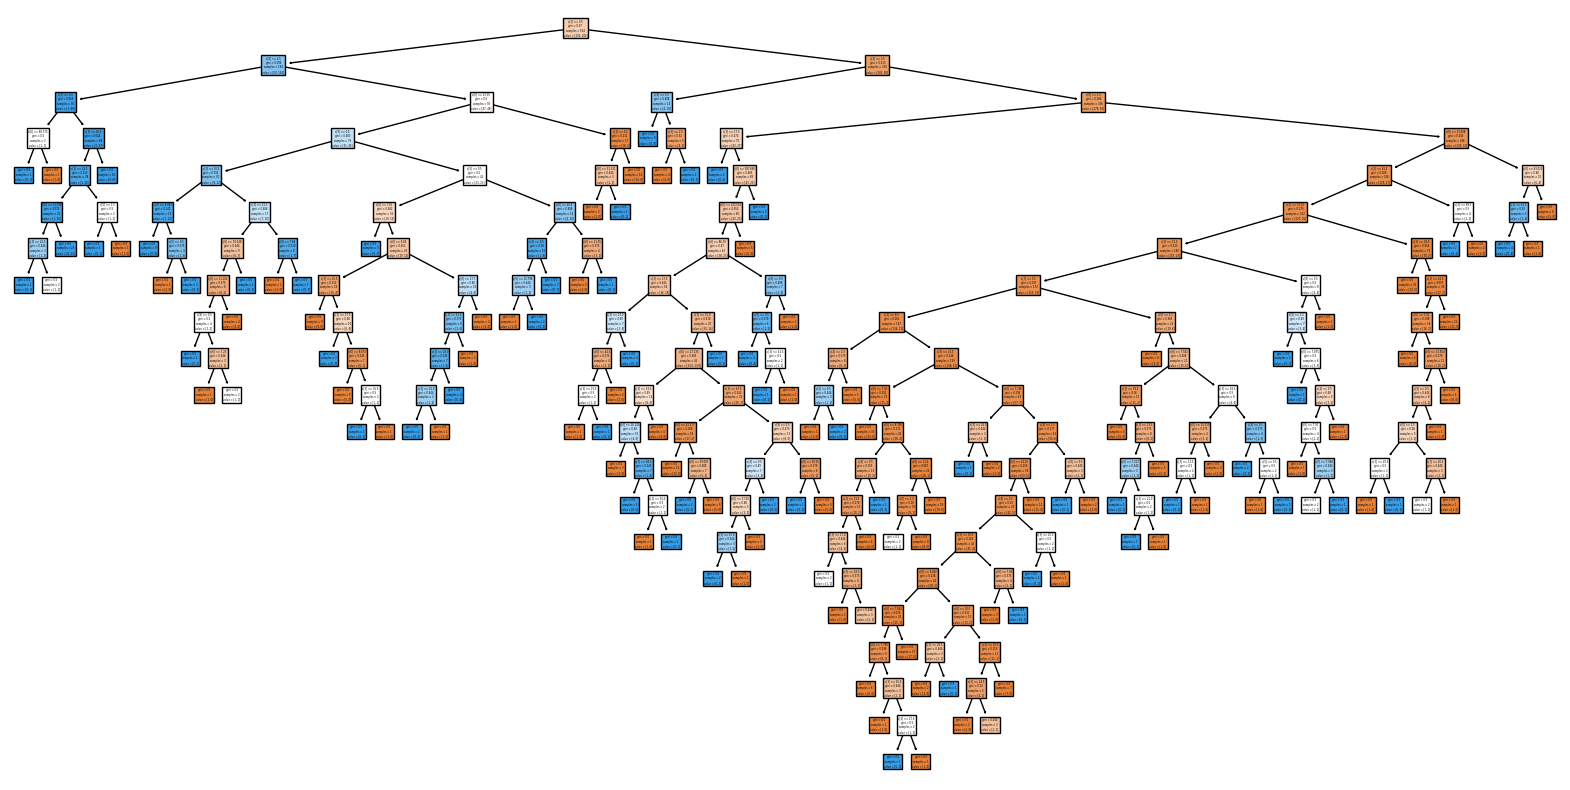

In [30]:
# Train Decision Tree - without max_depth restriction
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

# Plot Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dtc, filled=True)
plt.show()

We will now compute the model accuracy on the Development set.

In [54]:
# Generate predictions - Dev set
y_dev_predict = dtc.predict(x_dev)

# Accuracy - Dev set
accuracy = accuracy_score(y_dev, y_dev_predict)
print(f'Accuracy (Development set): {accuracy:.0%}')

Accuracy (Development set): 79%


We will now build the model with different values for *max_depth* (from 2 to 10), and we will store the accuracy of the Training and Development data, in order to plot them, and identify the ideal *max_depth* value.

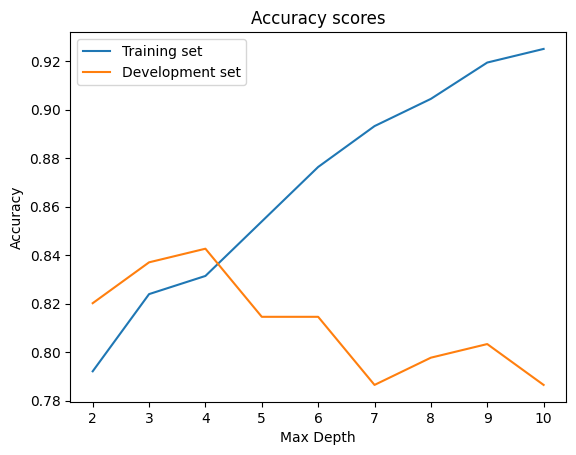

In [55]:
# Lists for storing accuracy scores at different max_depth values
accuracy_train = []
accuracy_dev = []

# Generate and store scores for max_depth values (range 2-10)
for max_depth in range(2, 11):
    # Train Decision Tree for each value of max_depth
    dtc = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dtc.fit (x_train, y_train)

    # Generate predictions
    y_train_predict = dtc.predict(x_train)
    y_dev_predict = dtc.predict(x_dev)

    # Accuracy scores
    acc_train = accuracy_score(y_train, y_train_predict)
    acc_dev = accuracy_score(y_dev, y_dev_predict)

    # Store accuracy scores
    accuracy_train.append(acc_train)
    accuracy_dev.append(acc_dev)

# Plot Training and Development accuracy
plt.plot(range(2,11), accuracy_train, label='Training set')
plt.plot(range(2,11), accuracy_dev, label='Development set')
plt.title('Accuracy scores')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Observations**

The accuracy of the Training set increases continuously with the value of *max_depth* (going well above 90%). 

The accuracy of the Development set increases, but starts going down with a *max_depth* value superior to 4, indicating overfitting beyong that point. 

The sweet spot seems to be around 4.

### Final model

We will apply this *max_depth* value of 4 to the model, then make predictions on the Test set, and calculate its accuracy.

We will also compare the accuracy of the Test and Training sets.

In [ ]:
# Optimal max_depth value
optimal_max_depth = 4

# Train Final Model
dtc = DecisionTreeClassifier(max_depth=optimal_max_depth, random_state=42)
dtc.fit (x_train, y_train)

# Generate Predictions on the Test set
y_test_predict = dtc.predict(x_test)

# Accuracy score 
accuracy_test = accuracy_score(y_test, y_test_predict)

# Display accuracy scores (Test set and Training set)
print('Accuracy of the Final model, with a max_depth of 4:')
print(f'• {accuracy_test:.0%} for the Test set.')
print(f'• {accuracy_train[2]:.0%} for the Training set.')


Accuracy of the Final model, with a max_depth of 4:
• 83% for the Test set.
• 84% for the Training set.


The final model shows an 83% accuracy for the Test set, which is well whithin acceptable accuracy levels.

The close results for the accuracy of the Test set (83%) and the Training set (84%) also show that the final model does not seem to be affected by overfitting. 

## Random Forests

**Task instructions:** 

* Create a *Bagged*, *Random Forest*, and *Boosted Tree* for the Titanic data set in the same way that you created a regular classification tree.
* From the Random Forest model, determine which of the features is the one that contributes the most to predicting whether a passenger survives or not.
* Pick one of these methods, and tune the parameters *n_estimators* and *max_depth*.
* Report the accuracy of all models and report which model performed the best, including the values for *n_estimators* and *max_depth* that the best model had.


In [649]:
# Import additional libraries
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

The first step will be to create a Base model + Bagging ensemble, using the optimal *max_depth* defined earlier in the task (i.e. value of 4), then fit the data, and extract the accuracy score. 

We will then repeat these steps for the other ensemble learning methodes (Random Forest, and Boosted Tree). 

#### Base model & Bagging Ensemble

In [650]:
# Variable n for n_estimators
n = 100

# Create base model
base = DecisionTreeClassifier(max_depth=4)
ensemble_bag = BaggingClassifier(estimator=base, n_estimators=n, random_state=7)

# Fit data
base.fit(x_train, y_train)
ensemble_bag.fit(x_train, y_train)

# Display accuracy scores
print('Accuracy Base model:', base.score(x_test, y_test))
print('Accuracy Bagging:', ensemble_bag.score(x_test, y_test))

Accuracy Base model: 0.8044692737430168
Accuracy Bagging: 0.8324022346368715


#### Ensemble Boosted Tree

Note: I have forced the use of the *SAMME* algorithm because the default algorithm (*SAMME.R*) will soon be deprecated. (The default setting triggers a *FutureWarning* message.)

In [651]:
# Create model - Boosted Tree
ensemble_boost = AdaBoostClassifier(n_estimators=n, random_state=7,
                                    algorithm='SAMME')

# Fit data
ensemble_boost.fit(x_train, y_train)

# Display accuracy scores
print('Accuracy Base model:', base.score(x_test, y_test))
print('Accuracy Boosted Tree:', ensemble_boost.score(x_test, y_test))

Accuracy Base model: 0.8044692737430168
Accuracy Boosted Tree: 0.7932960893854749


#### Ensemble Random Forest

In [652]:
# Create model - Random Forest
ensemble_forest = RandomForestClassifier(n_estimators=n, random_state=7)

# Fit data
ensemble_forest.fit(x_train, y_train)

# Display importance scores
feature_imp = pd.Series(ensemble_forest.feature_importances_).sort_values(ascending=False)

print('Importance score for each feature:')
feature_imp

Importance score for each feature:


3    0.261316
6    0.252653
1    0.151265
2    0.114619
0    0.082590
4    0.056512
5    0.044541
9    0.015650
7    0.011786
8    0.009070
dtype: float64

We see from the Random Forest model that the feature #3 (Age) is the one contributing the most to predict the passenger survival, followed closely by the feature #6 (Fare).

As a reminder, here are the different feature names: 

0. Pclass (Passenger Class)
1. Sex_female
2. Sex_male
3. Age
4. SibSp (Sibling/Spouse)
5. Parch (Parent/Children)
6. Fare
7. Embarked_C (Cherbourg, France)
8. Embarked_Q (Queenstown, Ireland)
9. Embarked_S (Southampton, England)


#### Drop features

The three variables "Port of Embarkation" (features 7, 8, and 9) can clearly be dropped, due to their very low importance score. 

Removing these three features will not have a big impact on the accuracy score, but it will reduce the training time.  

In [670]:
# Independent variables assigned to "x" (Drop values "Embarked_")
x = titanic_df[['Pclass', 'Sex_female', 'Sex_male', 'Age', 'SibSp', 'Parch', 'Fare']]

# Split data between Training and Test sets (80-20%) with updated x-axis
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Tuning the model

**max_depth** = We will use the *max_depth* value of 4, which we have defined as being the best one (section "Decision Tree"). 

**n_estimators** = So far we have used an arbitrary *n_estimators* value of 100 decision trees.  
Using the Bagging Classifier, we will test different values, in order to find the better compromise between accuracy/performance (memory use).  
We will try the values of 50, 100, 200, 500, 1000.

In [654]:
# Test values for n_estimators
values_n_est = [50, 100, 200, 500, 1000]

# Create and fit model for each n_estimators value,
# then display the accuracy score
print('Accuracy scores for n_estimators value of…')

i=0
for each in values_n_est:
    # Model
    tune_n_estimators = BaggingClassifier(estimator=base, n_estimators=values_n_est[i], random_state=7)
    
    # Fit data
    tune_n_estimators.fit(x_train, y_train)

    # Display accuracy scores
    print(f'{values_n_est[i]:<5}', 'Accuracy: ', tune_n_estimators.score(x_test, y_test))

    i+=1

Accuracy scores for n_estimators value of…


50    Accuracy:  0.8156424581005587
100   Accuracy:  0.8324022346368715
200   Accuracy:  0.8268156424581006
500   Accuracy:  0.8324022346368715
1000  Accuracy:  0.8268156424581006


After generating these accuracy scores a few times, only minimal variations are noticeable. 

The *n_estimators* values of 100 and 500 tend to provide the same accuracy score. 

Consequently, the best *n_estimators* value is situated between 50 and 200 trees. So, we will refine this figure, by increments of 25. 

In [656]:
# Test values for n_estimators
values_n_est = [50, 75, 100, 125, 150, 175, 200]

# Create and fit model for each n_estimators value,
# then display the accuracy score
print('Accuracy scores for n_estimators value of…')

i=0
for each in values_n_est:
    # Model
    tune_n_estimators = BaggingClassifier(estimator=base, n_estimators=values_n_est[i], random_state=7)
    
    # Fit data
    tune_n_estimators.fit(x_train, y_train)

    # Display accuracy scores
    print(f'{values_n_est[i]:<5}', 'Accuracy: ', tune_n_estimators.score(x_test, y_test))

    i+=1

Accuracy scores for n_estimators value of…
50    Accuracy:  0.8156424581005587
75    Accuracy:  0.8268156424581006
100   Accuracy:  0.8324022346368715
125   Accuracy:  0.8324022346368715
150   Accuracy:  0.8324022346368715
175   Accuracy:  0.8324022346368715
200   Accuracy:  0.8268156424581006


We see that the accuray score reaches its maximum for a *n_estimators* value of 100, but then stabilises, or decreases slightly. 

Therefore, **our optimal *n_estimators* value will be 100** (best compromise between accuracy score, and memory ressources).

### Model accuracy

We will now generate the accuracy scores for each model with the following settings:
* max_depth = 4
* n_estimators = 100

In [675]:
# Variable n for n_estimators
n = 100

# Base model
base = DecisionTreeClassifier(max_depth=4)
base.fit(x_train, y_train)  # Fit data

# Bagging
ensemble_bag = BaggingClassifier(estimator=base, n_estimators=n, random_state=7)
ensemble_bag.fit(x_train, y_train)  # Fit data

# Boosted Tree 
ensemble_boost = AdaBoostClassifier(n_estimators=n, random_state=7,
                                    algorithm='SAMME')
ensemble_boost.fit(x_train, y_train)  # Fit data

# Random Forest
ensemble_forest = BaggingClassifier(n_estimators=n, random_state=7)
ensemble_forest.fit(x_train, y_train)  # Fit data

# Display accuracy scores
print(f'{"Accuracy Base model:":<24}', base.score(x_test, y_test))
print(f'{"Accuracy Bagging:":<24}', ensemble_bag.score(x_test, y_test))
print(f'{"Accuracy Boosted Tree:":<24}', ensemble_boost.score(x_test, y_test))
print(f'{"Accuracy Random Forest:":<24}', ensemble_forest.score(x_test, y_test))

Accuracy Base model:     0.8044692737430168
Accuracy Bagging:        0.8156424581005587
Accuracy Boosted Tree:   0.7988826815642458
Accuracy Random Forest:  0.8044692737430168


**The best performing model is Bagging**, with an accuracy score of 81.56%.

The Base model and Random Forest have the same accuracy score of 80.45%.

The Boosted Tree model is the worst-performing one, with 79.89% (even lower than the Base model).